In this notebook, we will implement an autoencoder for rotating MNIST images.

In [ ]:
# Installing torch_snippets
!pip install -q torch_snippets
# importing libraries
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
# we will use gpu in case of availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 214 kB 51.3 MB/s 
     |████████████████████████████████| 57 kB 5.1 MB/s 
     |████████████████████████████████| 10.1 MB 57.3 MB/s 
     |████████████████████████████████| 51 kB 6.7 MB/s 


In [ ]:
# img_transform helps transform data from a dataset to tensors usable in code
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

# trn_ds = train dataset
# we will download MNIST dataset for trn_ds and we set train = True
trn_ds = MNIST('/content/', transform = img_transform, train = True, download = True)

# val_ds = validation dataset
# we will download MNIST dataset for val_ds but we must set train = False
val_ds = MNIST('/content/', transform = img_transform, train = False, download = True)

batch_size = 256

# trn_dl is the dataset that dataloader provides to us. It shuffles the initial MNIST dataset and groups them in batches of size 256
trn_dl = DataLoader(trn_ds, batch_size = batch_size, shuffle = True)

# val_dl is the dataset that dataloader provides to us. For validation dataset, we don't shuffle the initial dataset but we still group them in batches of size 256
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle = False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [ ]:
# AutoEncoder Class
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        
        # latend_dim is the dimension of features at the bottleneck layer, the layer that connects encoder and decoder 
        self.latend_dim = latent_dim
        
        # encoder is made of three linear layers each going through a ReLU activation function.
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64), 
            nn.ReLU(True), 
            nn.Linear(64, latent_dim))
        
        # decoder is made of three linear layers, the first two go through a ReLU activation function and lastly comes a Tanh.
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), 
            nn.ReLU(True),
            nn.Linear(64, 128), 
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28),
            nn.Tanh())
        
    # the forward function of the model. which must always be overridden.
    def forward(self, x):
        # convert x to a one dimensional input
        x = x.view(len(x), -1)
        # x goes through the encoder
        x = self.encoder(x)
        # x goes through the decoder
        x = self.decoder(x)
        # convert x back to its original dimensions.
        x = x.view(len(x), 1, 28, 28)
        return x

In [ ]:
# installing torch_summary
# The aim of using torch_summary is only to obtain a summary of the model we have just created.
!pip install torch_summary

from torchsummary import summary
# creating a sample AutoEncoder with 2000 as latent_dim
model = AutoEncoder(2000).to(device)

# output the summary of model
summary(model, torch.zeros(2,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 2000]                --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 2000]                130,000
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 64]                  128,064
|    └─ReLU: 2-7                         [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 128]                 8,320
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Linear: 2-10                      [-1, 784]                 101,136
|    └─Tanh: 2-11                        [-1, 784]         

In [ ]:
# train_batch is the function that trains our model.
# Inputs:
# input : the input should be a batch of size 256 of inputs and they should be initially on cpu.
# model : we always give our AutoEncoder model here. :)
# criterion : The system that we use for evaluating the loss function.
# optimizer : optimizer keeps the gradients of the model and it's used at backpropogation.
# ground_truth : the ground_truth labels of our input. Similar to input, ground_truth should be a batch of size 256 and they should be on cpu.
def train_batch(input, model, criterion, optimizer, ground_truth):
    # converting input to gpu. (In fact, we convert data to device but we assume beforehand that we have gpu and device = cuda)
    input = input.to(device)
    # similarly, convert ground_truth to gpu
    ground_truth = ground_truth.to(device)
    # preparing model for training
    model.train()
    # resetting all gradients in optimizer to 0. So that gradients saved from previous calls on train_batch won't affect this call of train_batch
    optimizer.zero_grad()
    # output is the output of input after it has gone through our model 
    output = model(input)
    # calculating loss using criterion and the ground_truth we were given
    loss = criterion(output, ground_truth)
    # backpropogating
    loss.backward()
    # our optimizer takes a step here. It means that parameters are updated once.
    optimizer.step()
    # loss is returned as output of this function
    return loss

# putting no_grad decorater at top of validation_batch function because at validation, we should not calculate gradients or update parameters
@torch.no_grad()
def validate_batch(input, model, criterion, ground_truth):
    # preparing model for evaluating
    model.eval()
    # converting input to gpu
    input = input.to(device)
    # converting ground_truth to gpu
    ground_truth = ground_truth.to(device)
    # output is the output of input after it has gone through our model
    output = model(input)
    # calculating loss using criterion and the ground_truth we were given 
    loss = criterion(output, ground_truth)
    # loss is returned as output of this function
    return loss

In [ ]:
# this function returns the 2*2 tensor that we must give as input to F.affine_grid if we want to rotate our image by theta degrees.
def get_rot_mat(theta):
    theta = torch.tensor(theta)
    return torch.tensor([[torch.cos(theta), -torch.sin(theta), 0],
                         [torch.sin(theta), torch.cos(theta), 0]])

# this function returns the rotated image of x by theta degreed. 
# dtype is the type that we use for data conversion. Here, we use FloatTensor
# x should be on cpu
def rot_img(x, theta, dtype):
    # rot_matt is the tensor that we must give to affine_grid.
    # Basically, the rotation of image is done through the use of matrix multiplication and in rotation, we requires tensors with cos(theta) sin(theta) in our computation.
    rot_matt = get_rot_mat(theta)[None, ...].type(dtype).repeat(x.shape[0],1,1)
    # converting x to gpu because F.grid_sample takes gpu input
    x = torch.from_numpy(x).to(device)
    # creating an affine grid
    gridd = F.affine_grid(rot_matt, x.size()).type(dtype)
    # x is a sample taken from gridd which is now prepared.
    x = F.grid_sample(x, gridd)
    return x

# As said before, we take dtype = FloatTensor to keep precision in computations.
dtype =  torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# This function does what its name suggests. :)
# data should be our original images in batches of size 256
def prepare_randomly_rotated_image(data):
    output = None
    # an iterator that increases by one for each image that we iterate through data
    iter = 0
    # iterating through the data
    for image in data:
        # rotate_degree_numpy is a number that is randomely generated from [0, 1] but later we will multiply it by 360. This variable is in 
        rotate_degree_numpy = torch.rand(1).numpy()
        rotate = 0
        for i in rotate_degree_numpy:
            rotate = i
        # rotate is now a number from [0, 360] 
        # rotate variable is basically rotate_degree_numpy, we just wanted it not to be of numpy type.
        rotate = rotate * 360
        
        # converting iamge to numpy
        image = image.cpu().numpy()
        # Here, we simply add a 1 to the first dimension of image so that later, its dimension will be appropriate for calling rot_img
        image = np.expand_dims(image, axis=0)
        # rotated_image is output of rot_img
        rotated_image = rot_img(image, rotate, dtype)
        
        if iter == 0:
            # At iter = 0, we change the previously output = None to output = rotated_image. This line is a kind of initialization.
            output = rotated_image
        else:
            # we concatenate the output of rotated_image to our output
            output = torch.cat((output, rotated_image), 0)
        # incrementing iterator
        iter += 1
    return output

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


EPOCH: 1.000	trn_loss: 0.249	val_loss: 0.202	(42.60s - 809.39s remaining)
EPOCH: 2.000	trn_loss: 0.192	val_loss: 0.180	(86.51s - 778.57s remaining)
EPOCH: 3.000	trn_loss: 0.171	val_loss: 0.161	(129.32s - 732.83s remaining)
EPOCH: 4.000	trn_loss: 0.154	val_loss: 0.145	(173.06s - 692.24s remaining)
EPOCH: 5.000	trn_loss: 0.143	val_loss: 0.138	(216.96s - 650.88s remaining)
EPOCH: 6.000	trn_loss: 0.137	val_loss: 0.132	(260.75s - 608.41s remaining)
EPOCH: 7.000	trn_loss: 0.132	val_loss: 0.130	(304.13s - 564.81s remaining)
EPOCH: 8.000	trn_loss: 0.129	val_loss: 0.125	(347.76s - 521.64s remaining)
EPOCH: 9.000	trn_loss: 0.126	val_loss: 0.123	(391.49s - 478.49s remaining)
EPOCH: 10.000	trn_loss: 0.123	val_loss: 0.120	(434.94s - 434.94s remaining)
EPOCH: 11.000	trn_loss: 0.121	val_loss: 0.118	(478.79s - 391.74s remaining)
EPOCH: 12.000	trn_loss: 0.119	val_loss: 0.116	(523.21s - 348.80s remaining)
EPOCH: 13.000	trn_loss: 0.117	val_loss: 0.115	(567.27s - 305.46s remaining)
EPOCH: 14.000	trn_loss:

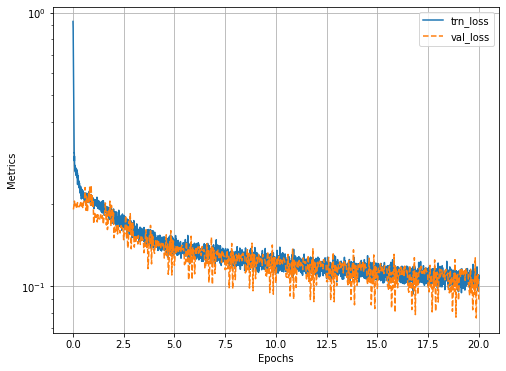

In [ ]:
# creating a sample model with latent_dim = 2000.
# The bigger the latent_dim, the more the features between the encoder and decoder.
# Undoubtedly, when more features are given to decoder, more information will be at the of decoder for producing the image.
# We choose latent_dim = 2000 here. 
model = AutoEncoder(2000).to(device)
# We choose MSE for criterion
criterion = nn.MSELoss()
# We choode AdamW for optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001, weight_decay = 1e-5)
# We train model through 20 epoches.
# More epochs usually results in better performance.
num_epochs = 20
# log is used for plotting.
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(trn_dl)
    
    # ix = 0 to N - 1
    for ix, (data, _) in enumerate(trn_dl):
        # data_rotated keeps the batch of rotated images of data
        data_rotated = prepare_randomly_rotated_image(data)
        # loss is the output of train_batch
        loss = train_batch(data_rotated, model, criterion, optimizer, data)
        # log records the postion and train loss.
        # This for loop is called N times for each epoch.
        # So the position should be epoch + (ix + 1) / N 
        log.record(pos = (epoch + (ix + 1)/N), trn_loss = loss, end = '\r')

    N = len(val_dl)

    # ix = 0 to N - 1
    for ix, (data, _) in enumerate(val_dl):
        # data_rotated keeps the batch of rotated images of data
        data_rotated = prepare_randomly_rotated_image(data)
        # loss is the output of validate_batch
        loss = validate_batch(data_rotated, model, criterion, data)
        # log records the postion and train loss.
        # This for loop is called N times for each epoch.
        # So the position should be epoch + (ix + 1) / N 
        log.record(pos=(epoch + (ix + 1)/N), val_loss = loss, end = '\r')
    
    log.report_avgs(epoch + 1)
 # plotting what we have stored in log   
log.plot(log = True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


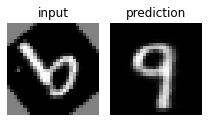

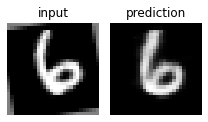

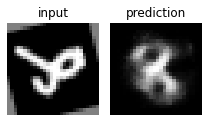

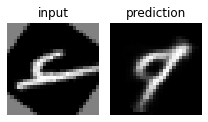

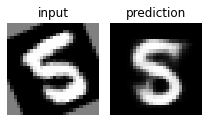

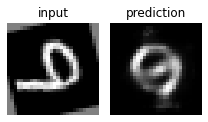

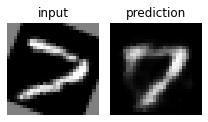

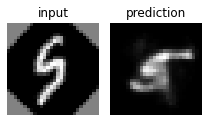

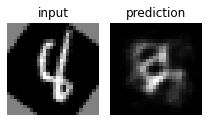

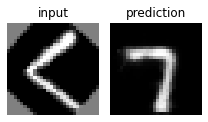

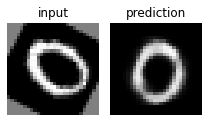

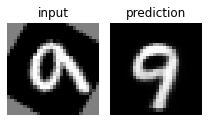

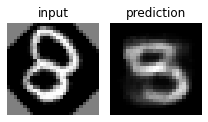

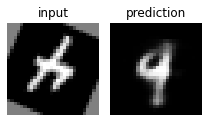

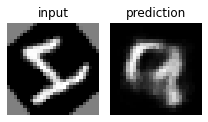

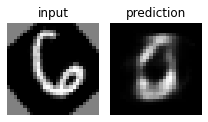

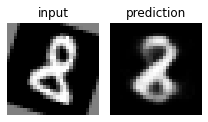

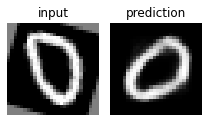

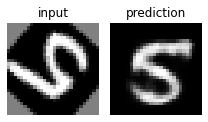

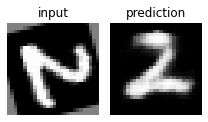

In [ ]:
# In this cell, we randomely choose 20 data inputs from validation set and see what the outputs have become.
for _ in range(20):
    # ix is a randome number from 0 to len(val_ds) - 1
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    im1 = im[None]
    im1 = prepare_randomly_rotated_image(im1)
    # converting im1 to gpu
    im1 = im1.to(device)
    # _im is output of im1 after it has gone through our model.
    _im = model(im1)[0]
    # we prepare a plot where in each row we depict two images. One the input and the second, our prediction.
    fig, ax = plt.subplots(1, 2, figsize=(3,3))
    im1 = im1[0]
    show(im1[0], ax = ax[0], title = 'input')
    show(_im[0], ax = ax[1], title = 'prediction')
    plt.tight_layout()
    plt.show()

As results show, the model has predicted 9, 6, 4, 5, 7, 0, 8 well.

One of the mistakes of this model is that we have taken the MNIST itself as the ground truth label, but this is wrong from stratch.

A simple proof is the third image from the last, where the 0 digit is given as input. We can see that the predicted 0 isn't upright but if we tilt our head at the input to find out the original image input ( before rotation ) we see that the original image itself was a tilted 0. So, when we were reducing the loss of model, our model was actually trying to output sth like this and so, when it has given a tilted 0 as output, it means it did a good job at this input.

For example, one huge problem is that 6 and 9 are basically the same and they are simply 180 rotations of each other, so basically when we are given a rotated 6, we should either equally output 6 and 9 or simply say that the output cannot be given and we are uncertain about it.

Simply, assume a rotated 6 and rotated 9 that have accidently became the same image. So in our model both of these have been given as input to our model. But the ground truth label for one of them is 6 and for the other is 9. This confuses our model as it is unable to learn or converge to anywhere appropriately. But it has an interesting consequence, our model equally tries to generate both 6 and 9 and if you put a 6 and 9 next to each other, you find a 0 with a crossed line inside it, similar to how the THETA variable is written and if you look at the 6th input, this is basically what has happened. A combination of 6 and 9 have been given as output. But in some cases, our model has appropriately given the output. For example, in the first example, we see a 9 that is drawn straight and our model has correctly learned this straight part of 9 digit and gave a good output.

Moreover, the generativity of model is apparent from the outputs. The digits created at output are not necessarily simliar to the inputs in terms of brightness, thickness or size, which suggests our model is generative.

In [ ]:
# preparing google colab to have access to drive.
# This cell doesn't have to be run if you have done it before.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
model_save_name = 'model.pth.tar'
path = f'/content/gdrive/My Drive/{model_save_name}'
# we save model.state_dict() and optimizer.state_dict()
# we could save other things if we wanted too.
torch.save({
    'state_dict': model.state_dict(),
    'optimizer' : optimizer.state_dict(),
}, path)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


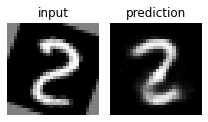

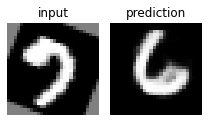

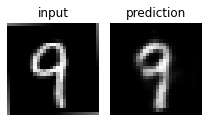

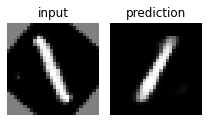

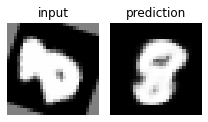

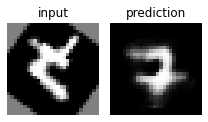

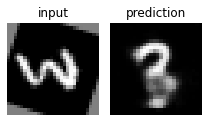

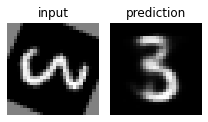

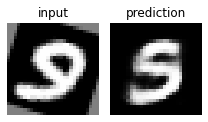

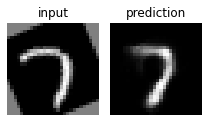

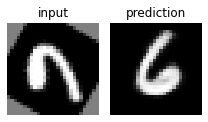

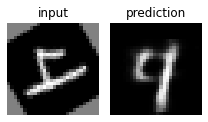

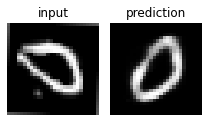

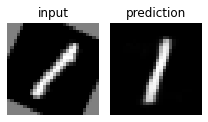

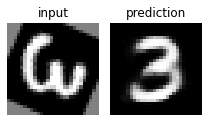

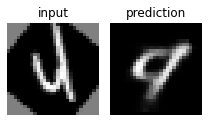

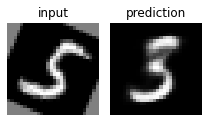

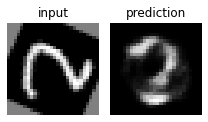

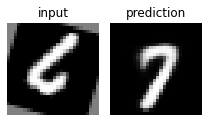

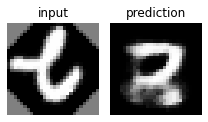

In [ ]:
# This code cell is simply for checking that our model has been saved correctly. 
# We load it and choose 20 random data from validation dataset and see if results were similar to what we saw before.
checkpoint = torch.load(f'/content/gdrive/My Drive/model.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

for _ in range(20):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    im1 = im[None]
    im1 = prepare_randomly_rotated_image(im1)
    im1 = im1.to(device)
    _im = model(im1)[0]
    fig, ax = plt.subplots(1, 2, figsize = (3,3))
    im1 = im1[0]
    show(im1[0], ax = ax[0], title = 'input')
    show(_im[0], ax = ax[1], title = 'prediction')
    plt.tight_layout()
    plt.show()